# South African Heart Disease
Here we present an analysis of binary data to illustrate the traditional statistical use of the logistic regression model. The data in Figure 4.12 are a subset of the Coronary Risk-Factor Study (CORIS) baseline survey, carried out in three rural areas of the Western Cape, South Africa (Rousseauw et al., 1983). The aim of the study was to establish the intensity of ischemic heart disease risk factors in that high-incidence region. The data represent white males between 15 and 64, and the response variable is the presence or absence of myocardial infarction (MI) at the time of the survey (the overall prevalence of MI was 5.1% in this region). There are 160 cases in our data set, and a sample of 302 controls.

A retrospective sample of males in a heart-disease high-risk region of the Western Cape, South Africa. There are roughly two controls per case of CHD. Many of the CHD positive men have undergone blood pressure reduction treatment and other programs to reduce their risk factors after their CHD event. In some cases the measurements were made after these treatments. These data are taken from a larger dataset, described in  Rousseauw et al, 1983, South African Medical Journal. 

Variables:

|         |                                                       |
|---------|-------------------------------------------------------|
|sbp      |systolic blood pressure                                |
|tobacco  |cumulative tobacco (kg)                                |
|ldl      |low densiity lipoprotein cholesterol                   |
|adiposity|                                                       |
|famhist  |family history of heart disease (Present, Absent)      |
|typea    |type-A behavior                                        |
|obesity  |                                                       |
|alcohol  |current alcohol consumption                            |
|age      |age at onset                                           |
|chd      |response, coronary heart disease                       |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# load training and test data set from file
df = pd.read_csv("../data/South African Heart Disease.txt")
# encode famhist with dummy 0-1
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
target = ['chd']
features = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
df[features + target].head()

,sbp,tobacco,ldl,famhist,obesity,alcohol,age,chd
0,160,12.00,5.73,1,25.30,97.20,52,1
1,144,0.01,4.41,0,28.87,2.06,63,1
2,118,0.08,3.48,1,29.14,3.81,46,0
3,170,7.50,6.41,1,31.99,24.26,58,1
4,134,13.60,3.50,1,25.99,57.34,49,1


/home/andrey/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


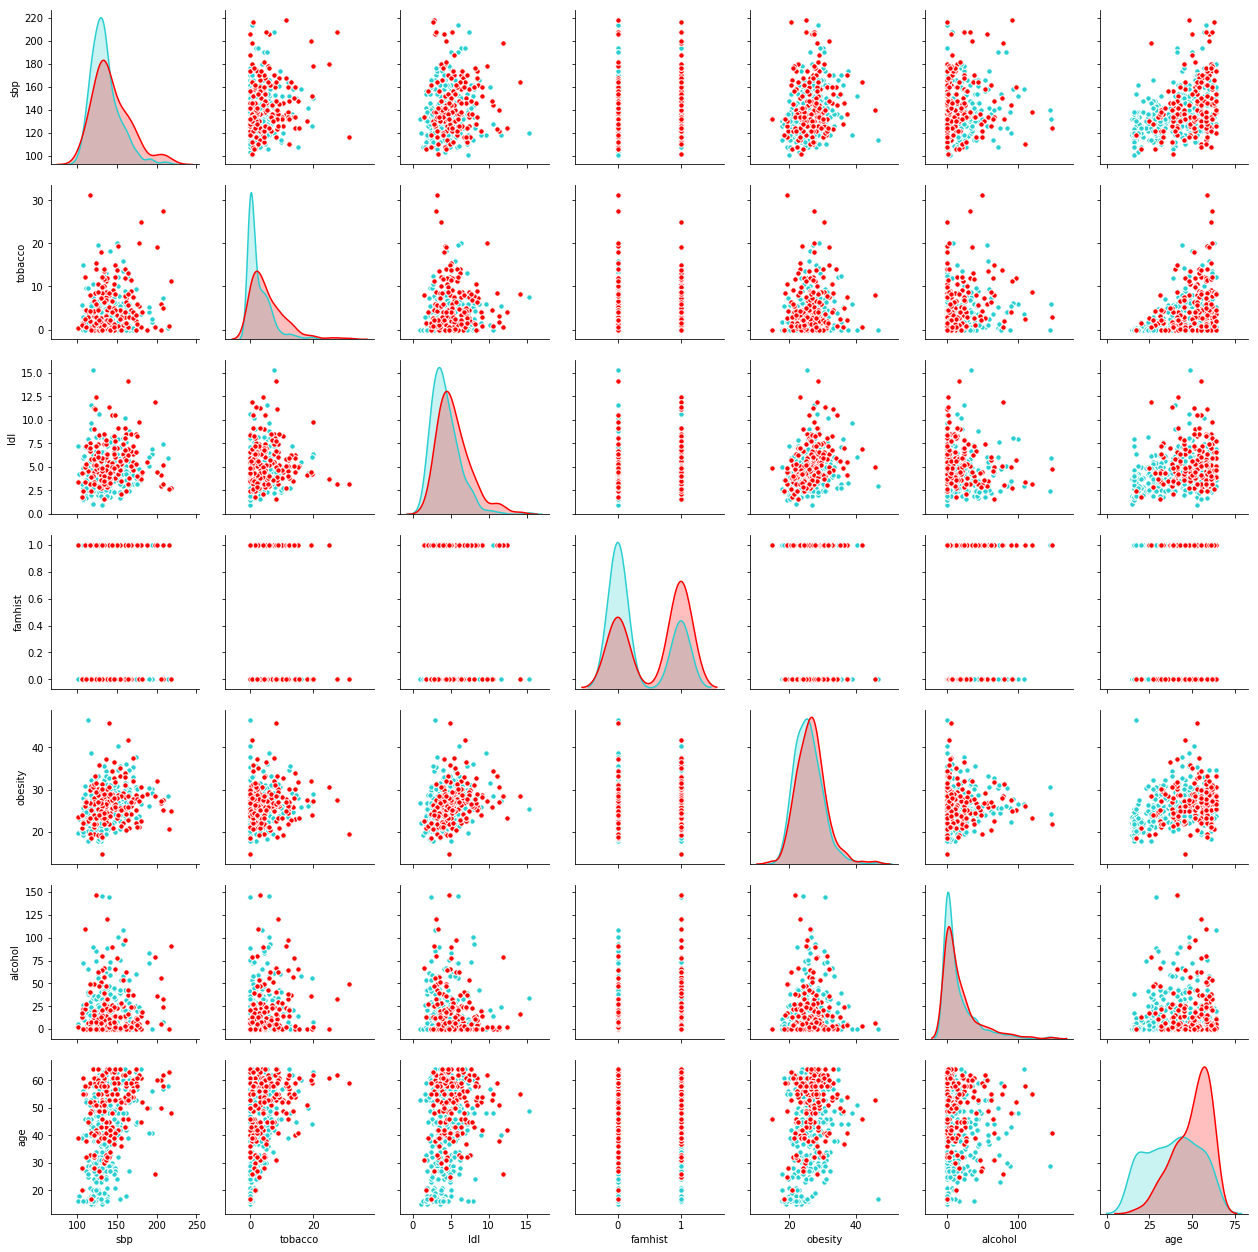

In [3]:
# PAGE 123. FIGURE 4.12. A scatterplot matrix of the South African heart disease data.
#           Each plot shows a pair of risk factors, and the cases and controls are color coded
#           (red is a case). The variable family history of heart disease (famhist) is binary
#           (yes or no).
g = sns.pairplot(df, vars=features, kind="scatter", hue=target[0], 
                 palette=['#29CFD0', '#FF0000'],
                 plot_kws=dict(s=30, linewidth=1))
g._legend.remove()

In [4]:
# convert data to X, y np.arrays
X, y = df[features].values, df[target].values
y_flat = np.squeeze(y)

## Logistic Regression

In [5]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [6]:
# PAGE 122. We fit a logistic-regression model by maximum likelihood, giving the
#           results shown in Table 4.2. This summary includes Z scores for each of the
#           coefficients in the model (coefficients divided by their standard errors); a
#           nonsignificant Z score suggests a coefficient can be dropped from the model.
#           Each of these correspond formally to a test of the null hypothesis that the
#           coefficient in question is zero, while all the others are not (also known as
#           the Wald test). A Z score greater than approximately 2 in absolute value
#           is significant at the 5% level.
lr = sm.Logit(y, sm.add_constant(X)).fit(disp=False)

In [7]:
# PAGE 122. TABLE 4.2. Results from a logistic regression fit to the South African heart
#           disease data.

#           There are some surprises in this table of coefficients, which must be 
#           interpreted with caution. Systolic blood pressure (sbp) is not significant! 
#           Nor is obesity, and its sign is negative. This confusion is a result of the 
#           correlation between the set of predictors. On their own, both sbp and obesity
#           are significant, and with positive sign. However, in the presence of many
#           other correlated variables, they are no longer needed (and can even get a
#           negative sign).
result = zip(['(Intercept)'] + features, lr.params, lr.bse, lr.tvalues)
print('               Coefficient   Std. Error   Z Score')
print('-------------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>12}   {coefficient:>11.3f}   {std_err:>10.3f}  {z_score:>8.3f}')

               Coefficient   Std. Error   Z Score
-------------------------------------------------
 (Intercept)        -4.130        0.964    -4.283
         sbp         0.006        0.006     1.023
     tobacco         0.080        0.026     3.034
         ldl         0.185        0.057     3.218
     famhist         0.939        0.225     4.177
     obesity        -0.035        0.029    -1.187
     alcohol         0.001        0.004     0.136
         age         0.043        0.010     4.181


## Features Selection
At this stage the analyst might do some model selection; find a subset of the variables that are sufficient for explaining their joint effect on the prevalence of chd. One way to proceed by is to drop the least significant coefficient, and refit the model. This is done repeatedly until no further terms can be dropped from the model.

In [8]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

/home/andrey/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [9]:
# PAGE 124. A better but more time-consuming strategy is to refit each of the models
#           with one variable removed, and then perform an analysis of deviance to
#           decide which variable to exclude. The residual deviance of a fitted model
#           is minus twice its log-likelihood, and the deviance between two models is
#           the difference of their individual residual deviances (in analogy to sums-of
#           squares).
def deviance(X, y, model):
    return 2*log_loss(y_flat, model.predict_proba(X))

def total_deviance(X, y, model):
    return deviance(X, y, model)*X.shape[0]

lr = LogisticRegression(solver='lbfgs', max_iter=100000, C=10e10)
features_selected = features[:]
X_selected = X.copy()
while True:
    current_dev = total_deviance(X_selected, y, lr.fit(X_selected, y_flat))
    i_to_remove, min_dev = None, None
    for i, name in enumerate(features_selected):
        X_tmp = np.delete(X_selected, i, 1)
        dev = total_deviance(X_tmp, y, lr.fit(X_tmp, y_flat))
        if i_to_remove is None or min_dev > dev:
            i_to_remove, min_dev = i, dev
    lrt = min_dev - current_dev
    p_value = 1-stats.chi2.cdf(lrt, df=1)
    if p_value < 0.05:
        break
    X_selected = np.delete(X_selected, i_to_remove, 1)
    print(f'REMOVE: {features_selected.pop(i_to_remove)}')

REMOVE: alcohol
REMOVE: sbp
REMOVE: obesity


In [10]:
# PAGE 124. TABLE 4.3. Results from stepwise logistic regression ﬁt to South African heart 
#           disease data.
lr = sm.Logit(y, sm.add_constant(X_selected)).fit(disp=False)
result = zip(['(Intercept)'] + features_selected, lr.params, lr.bse, lr.tvalues)
print('               Coefficient   Std. Error   Z Score')
print('-------------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>12}   {coefficient:>11.3f}   {std_err:>10.3f}  {z_score:>8.2f}')
    
# PAGE 124. How does one interpret a coefficient of 0.081 (Std. Error = 0.026) for
#           tobacco, for example? Tobacco is measured in total lifetime usage in kilograms, 
#           with a median of 1.0kg for the controls and 4.1kg for the cases. Thus
#           an increase of 1kg in lifetime tobacco usage accounts for an increase in the
#           odds of coronary heart disease of exp(0.081) = 1.084 or 8.4%. Incorporating 
#           the standard error we get an approximate 95% confidence interval of
#           exp(0.081 ± 2 × 0.026) = (1.03, 1.14).

               Coefficient   Std. Error   Z Score
-------------------------------------------------
 (Intercept)        -4.204        0.498     -8.44
     tobacco         0.081        0.026      3.16
         ldl         0.168        0.054      3.09
     famhist         0.924        0.223      4.14
         age         0.044        0.010      4.52


## L1 Regularized Logistic Regression

In [11]:
from sklearn.preprocessing import StandardScaler
from math import log

In [12]:
# PAGE 126.  The variables were all standardized to have unit variance.
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [13]:
# PAGE 126. FIGURE 4.13. L1 regularized logistic regession coefficients for the South
#           African heart disease data, plotted as a function of the L1 norm. The variables
#           were all standardized to have unit variance. The profiles are computed exactly at
#           each of the plotted points.
lr = sm.Logit(y, sm.add_constant(X_scaled))
alpha = np.linspace(0, 82, 100)
b_hat = np.vstack([lr.fit_regularized(disp=False, alpha=a).params[1:] for a in alpha])
b_pow = np.sum(np.abs(b_hat), axis=1)

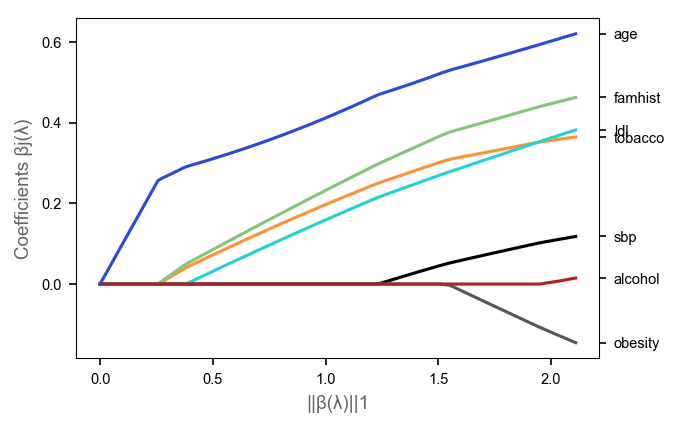

In [14]:
# let's plot the L1 regularization path for the South African heart disease data
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
fig, ax1 = plt.subplots(figsize=(4.5, 3), dpi=150)
colors = ['#000101', '#FF9234', '#29D0D0', '#85C57A', '#57575A', '#AD2323', '#2A4BD7']
GRAY4 = '#646369'
for i in range(7):
    ax1.plot(b_pow, b_hat[:, i], color=colors[i])
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
plt.setp(ax2, yticks=b_hat[0], yticklabels=features)
for i in ax1.get_yticklabels() + ax1.get_xticklabels() + ax2.get_yticklabels():
    i.set_fontsize(7)
ax1.set_xlabel('||β(λ)||1', color=GRAY4, fontsize=9)
_ = ax1.set_ylabel('Coefficients βj(λ)', color=GRAY4, fontsize=9)

## Natural Cubic Splines Basis Expansion

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [16]:
# sklearn doesn't have natural cubic spline basis expansion
# so, let's implement it with fit-transform method to be used
# in a pipeline
class NaturalCubicSplineFeatures():
    # you can specify knots locations or degrees of freedom
    def __init__(self, knots=None, df=None):
        self.knots = knots
        self.df = df
    
    @staticmethod
    def dk(x, xi_k, xi_K):
        return (max(0, x-xi_k)**3) / (xi_K-xi_k)
    
    @staticmethod
    def do_nc_expansion(x, xis):
        X = np.zeros(shape=(x.shape[0], len(xis)-1))
        for i in range(X.shape[0]):
            X[i, 0] = x[i]
            for k in range(2, len(xis)):
                X[i, k-1] = NaturalCubicSplineFeatures.dk(x[i], xis[k-2], xis[-1]) - \
                            NaturalCubicSplineFeatures.dk(x[i], xis[-2], xis[-1])
        return X
    
    def fit(self, X, y=None):
        if self.df is not None:
            quantiles = np.linspace(0, 1, self.df+1)
            self.knots = []
            for i in range(X.shape[1]):
                self.knots.append(np.unique(np.quantile(X[:,i], quantiles)))            
        # calculate the number of parameters in each component term
        self.dofs_ = np.array([len(k)-1 for k in self.knots])
        pts = [0] + list(np.cumsum(self.dofs_))
        self.pos_ = [(pts[i-1], pts[i]-1) for i in range(1, len(pts))]
        return self
    
    def transform(self, X):
        h = []
        for i in range(X.shape[1]):
            h.append(NaturalCubicSplineFeatures.do_nc_expansion(X[:,i], self.knots[i]))
        result = np.hstack(h)
        return result

In [17]:
# PAGE 146. We use four natural spline bases for each term in the model. For example,
#           with X1 representing sbp, h1(X1) is a basis consisting of four basis functions. 
#           This actually implies three rather than two interior knots (chosen at
#           uniform quantiles of sbp), plus two boundary knots at the extremes of the
#           data, since we exclude the constant term from each of the hj.
ncs = NaturalCubicSplineFeatures(df=4)
add_intercept = FunctionTransformer(lambda X: sm.add_constant(X), validate=True)
prep = Pipeline([('scale_features', StandardScaler()),
                 ('expand_basis', ncs),
                 ('scale_basis', StandardScaler()),
                 ('add_intercept_column', add_intercept)])

In [18]:
# PAGE 146. We carried out a backward stepwise deletion process, dropping terms
#           from this model while preserving the group structure of each term, rather
#           than dropping one coefficient at a time. The AIC statistic (Section 7.5) was
#           used to drop terms, and all the terms remaining in the final model would
#           cause AIC to increase if deleted from the model (see Table 5.1).
features_selected = features[:]
X_selected = X.copy()
aic_dict = None
while True:
    aic_dict = dict()
    current_aic = sm.Logit(y, prep.fit_transform(X_selected)).fit_regularized(
        method='l1', maxiter=1000, disp=False).aic
    aic_dict['none'] = current_aic
    i_to_remove, min_aic = None, current_aic
    for i, name in enumerate(features_selected):
        X_tmp = np.delete(X_selected, i, 1)
        # use statsmodel library here, because it has AIC
        aic = sm.Logit(y, prep.fit_transform(X_tmp)).fit_regularized(
            method='l1', maxiter=1000, disp=False).aic
        aic_dict[name] = aic
        if aic < current_aic:
            i_to_remove, min_aic = i, aic
    if i_to_remove is None:
        break
    X_selected = np.delete(X_selected, i_to_remove, 1)
    print(f'REMOVE: {features_selected.pop(i_to_remove)}')
print('Features selected', features_selected)

REMOVE: alcohol
Features selected ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age']


In [19]:
# save features' min-max to use in plotting 
X_min, X_max = np.min(X_selected, axis=0), np.max(X_selected, axis=0)

In [20]:
# PAGE 146. At this point the model is like any other linear logistic model, and the algorithms
#           described in Section 4.4.1 apply
lr = LogisticRegression(solver='lbfgs', max_iter=100000, C=10e10, fit_intercept=False)
model = Pipeline([('prepare', prep),
                  ('logistic', lr)])
dev_dict = dict()
for i, name in enumerate(features_selected):
    X_tmp = np.delete(X_selected, i, 1)
    dev_dict[name] = total_deviance(X_tmp, y, model.fit(X_tmp, y_flat))
model.fit(X_selected, y_flat)
dev_dict['none'] = deviance(X_selected, y, model)*X_selected.shape[0]

In [21]:
print(f'    Terms   Df   Deviance      AIC      LRT   P-value')
print(f'-----------------------------------------------------')
print(f'     none          {dev_dict["none"]:.2f}   {aic_dict["none"]:.2f}')
for i, name in enumerate(features_selected):
    lrt = dev_dict[name] - dev_dict["none"]
    p_value = 1-stats.chi2.cdf(lrt, df=ncs.dofs_[i])
    print(f'{name:>9} {ncs.dofs_[i]:>3} {dev_dict[name]:>11.2f} {aic_dict[name]:8.2f}'
          f'{lrt:>9.3f} {p_value:9.3f}')

    Terms   Df   Deviance      AIC      LRT   P-value
-----------------------------------------------------
     none          459.54   503.53
      sbp   4      469.33   505.33    9.792     0.044
  tobacco   4      470.48   506.48   10.937     0.027
      ldl   4      474.48   510.48   14.945     0.005
  famhist   1      480.38   522.38   20.840     0.000
  obesity   4      467.93   503.93    8.390     0.078
      age   4      485.76   521.77   26.226     0.000


In [22]:
# PAGE 146. [See covariance matrix estimation]
H = prep.transform(X_selected)
predProbs = model.predict_proba(X_selected)
W = np.diagflat(np.product(predProbs, axis=1))
cov = np.linalg.inv(H.T @ W @ H)

In [23]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

# linspace features 
x_axis_values = np.vstack([np.linspace(X_min[i], X_max[i], 100)
                           for i in range(X_min.shape[0])]).T
x_axis_values_ = prep.transform(x_axis_values)

def plot_term_natural_spline_function(ax1, feature_i, name):
    basis_start, basis_end = ncs.pos_[feature_i]
    basis_start += 1
    basis_end += 1
    feature_basis = x_axis_values_[:,basis_start:basis_end+1]
    feature_cov = cov[basis_start:basis_end+1, basis_start:basis_end+1]
    err = [2*np.sqrt(feature_basis[t:t+1,:] @ feature_cov @ feature_basis[t:t+1,:].T)[0, 0]
           for t in range(100)]
    err = np.array(err)
    x_values = x_axis_values[:,feature_i]
    y_values = np.squeeze(feature_basis @ lr.coef_[:,basis_start:basis_end+1].T)
    y_values_low = y_values - err
    y_values_high = y_values + err
    
    ax1.fill_between(x_values, y_values_low, y_values_high, color='#FFEC8B')
    ax1.plot(x_values, y_values, color='#00FF00', linewidth=0.8)
    
    y_from, y_to = ax1.get_ylim()
    for i in range(X_selected.shape[0]):
        x = X_selected[i, feature_i]
        ax1.plot([x, x], [y_from, y_from+(y_to-y_from)*0.02], 
                 color='red', linewidth=0.5)
    ax1.set_ylim(y_from, y_to)
    
    for l in ax1.get_yticklabels() + ax1.get_xticklabels():
        l.set_fontsize(6)
    ax1.set_xlabel(f'{name}', color=GRAY4, fontsize=8)
    ax1.set_ylabel(f'f({name})', color=GRAY4, fontsize=8)

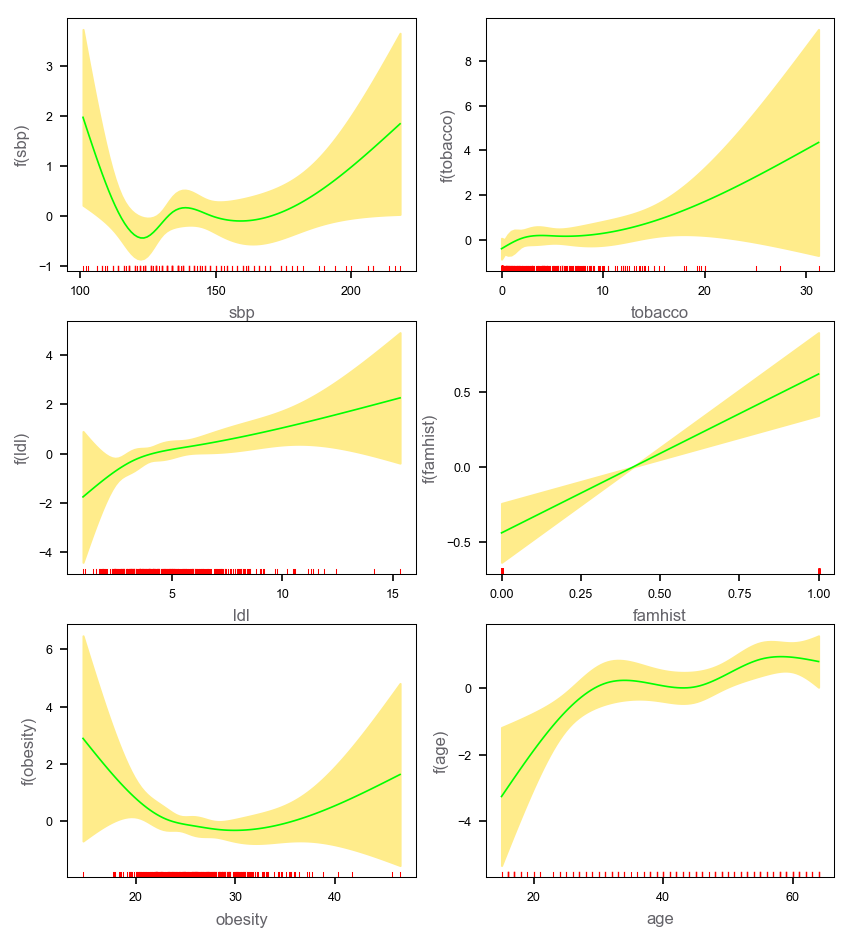

In [24]:
# PAGE 147. FIGURE 5.4. Fitted natural-spline functions for each of the terms in the final
#           model selected by the stepwise procedure. Included are pointwise standard-error
#           bands. The rug plot at the base of each figure indicates the location of each of the
#           sample values for that variable (jittered to break ties).
fig, axarr = plt.subplots(3,2, figsize=(3.3*2, 2.3*3), dpi=150)
plt.subplots_adjust(bottom=0.05)
plot_term_natural_spline_function(axarr[0, 0], 0, 'sbp')
plot_term_natural_spline_function(axarr[0, 1], 1, 'tobacco')
plot_term_natural_spline_function(axarr[1, 0], 2, 'ldl')
plot_term_natural_spline_function(axarr[1, 1], 3, 'famhist')
plot_term_natural_spline_function(axarr[2, 0], 4, 'obesity')
plot_term_natural_spline_function(axarr[2, 1], 5, 'age')

## Thin-Plate Spline
I did not find a suitable thin-plate splines implementation for Python. Tried to implement myself, but didn't succeed. Will use the Rbf, its result is something similar to the one in the book.

In [25]:
from scipy.spatial import ConvexHull
from scipy.interpolate import Rbf
from matplotlib import cm

# checks whether a point is inside a convex hull
def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)

In [26]:
# remove 1 outlier because it greatly expands the convex hull
df1 = df[~((df.age < 20) & (df.obesity > 45))]

x, y, z = df1.age.values, df1.obesity.values, df1.sbp.values
# don't know why, but relocating response influences on approximation
# scaling does no have any effect
mean_z = np.mean(z)
z = z - mean_z

# build a convex hull
xy = np.vstack((x, y)).T
hull = ConvexHull(xy)

# calculate approximation on whole x-y range
xi, yi = np.meshgrid(np.linspace(np.min(x), np.max(x), 500), 
                     np.linspace(np.min(y), np.max(y), 500))
rbfi = Rbf(x, y, z, smooth=30, function='multiquadric')
zi = rbfi(xi, yi)

# remove all points outside the convex hull
for i in range(xi.shape[0]):
    for j in range(xi.shape[1]):
        if not point_in_hull([xi[i, j], yi[i, j]], hull):
            zi[i, j] = None

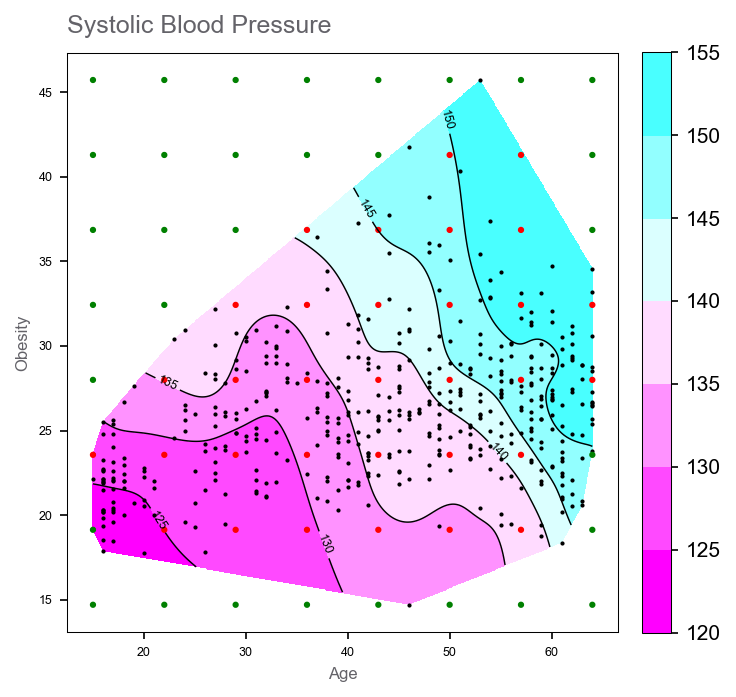

In [27]:
# PAGE 166. FIGURE 5.12. A thin-plate spline fit to the heart disease data, displayed as a
#           contour plot. The response is systolic blood pressure, modeled as a function
#           of age and obesity. The data points are indicated, as well as the lattice of points
#           used as knots. Care should be taken to use knots from the lattice inside the convex
#           hull of the data (red), and ignore those outside (green).
levels = [120, 125, 130, 135, 140, 145, 150, 155]
colors = ['#FF00FF', '#FF49FF', '#FF92FF', '#FFDBFF',
          '#DBFFFF', '#92FFFF', '#49FFFF', '#00FFFF']
fig, ax1 = plt.subplots(figsize=(5.2, 5.2), dpi=150)
cf = ax1.contourf(xi, yi, zi+mean_z, levels=levels, colors=colors)
cs = ax1.contour(xi, yi, zi+mean_z, levels=levels, colors='black', linewidths=0.7)
ax1.clabel(cs, inline=1, fontsize=6, fmt='%1.0f')
ax1.scatter(x, y, s=1, color='black')
ax1.set_aspect(1.66)
x_vals = np.linspace(15, 64, 8)
y_vals = np.linspace(14.7, 45.72, 8)
latice = np.transpose([np.tile(x_vals, 8), np.repeat(y_vals, 8)])
colors = [('green', 'red')[point_in_hull(latice[i], hull)] for i in range(latice.shape[0])]
ax1.scatter(latice[:,0], latice[:,1], s=4, color=colors)
for l in ax1.get_yticklabels() + ax1.get_xticklabels():
    l.set_fontsize(6)
ax1.set_xlabel('Age', color=GRAY4, fontsize=8)
ax1.set_ylabel('Obesity', color=GRAY4, fontsize=8)
fig.colorbar(cf, ax=ax1, fraction=0.048, pad=0.04)
_ = ax1.text(12.5, 48.5, 'Systolic Blood Pressure', color=GRAY4, fontsize=12)

## Local Linear Logistic Regression
The book does not contain a detailed description of how the local linear regression was performed. We will use the Epanechnikov quadratic kernel, and bootstrap the confidence intervals. The confidence intervals are very wide at the end. This is because there are very few observations in the area of maximum values.

In [28]:
from sklearn.utils import resample

# sklearn doesn't have local linear logistic regression implemented
# let's implement it ourselves
class LocalLogisticRegression():
    def __init__(self, l=1):
        self.l = l # lambda parameter for Epanechnikov quadratic kernel
        self.X, self.y = None, None
    def fit(self, X, y, sample_weight=None):
        self.X, self.y = X, y
    def Kl(self, x0):
        t = np.abs(self.X - x0)/self.l
        result = (t<=1)*3/4*(1-t**2)
        return np.squeeze(result)
    def predict_proba(self, X):
        lr = LogisticRegression(solver='lbfgs', 
                                max_iter=100000, 
                                C=10e10, 
                                fit_intercept=True)
        result = np.zeros(shape=(X.shape[0], 2))
        for i in range(X.shape[0]):
            lr.fit(self.X, self.y, sample_weight=self.Kl(X[i]))
            result[i] = lr.predict_proba([X[i]])
        return result

In [29]:
def bootstrap_local_logistic_regression(X, y, X_, l):
    result = np.zeros(shape=(100, X_.shape[0]))
    lr = LocalLogisticRegression(l)
    for i in range(result.shape[0]):
        lr.fit(*resample(X, y))
        result[i] = lr.predict_proba(X_)[:, 1]
    return result

In [30]:
# target
y = df.chd.values
# bootstrap local linear regression for sbp
X_sbp = df[['sbp']].values
X_sbp_ = np.linspace(np.min(X_sbp), np.max(X_sbp), 100).reshape(100, 1)
result_sbp = bootstrap_local_logistic_regression(X_sbp, y, X_sbp_, 39)
# bootstrap local linear regression for obesity
X_obesity = df[['obesity']].values
X_obesity_ = np.linspace(np.min(X_obesity), np.max(X_obesity), 100).reshape(100, 1)
result_obesity = bootstrap_local_logistic_regression(X_obesity, y, X_obesity_, 10)

/home/andrey/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


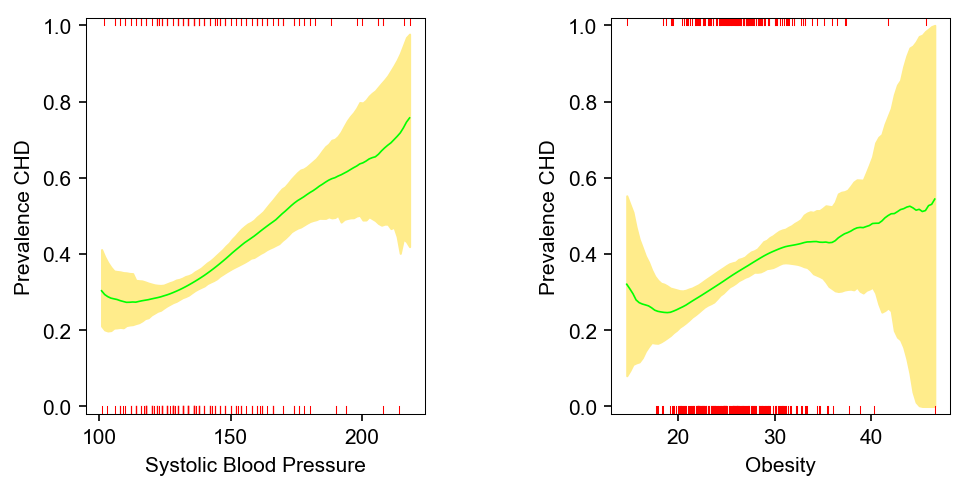

In [31]:
def plot_local_regression_result(ax, x_label, x_vals, x, result):
    ax.fill_between(x[:,0], 
                    np.percentile(result, 10, axis=0), 
                    np.percentile(result, 90, axis=0),
                    color='#FFEC8B')
    ax.plot(x[:,0], np.mean(result, axis=0), color='#00FF00', linewidth=0.8)
    for i in range(x_vals.shape[0]):
        y_from = (-0.02, 1)[y[i]]
        ax.plot([x_vals[i, 0], x_vals[i, 0]], 
                 [y_from, y_from+0.02], 
                 color='red', linewidth=0.5)
    ax.set_ylim(-0.02, 1.02)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Prevalence CHD')

    
fig, axarr = plt.subplots(1,2, figsize=(7.2, 3.5), dpi=150)
plt.subplots_adjust(left=0.1, bottom=None, right=None, top=None, wspace=0.55, hspace=None)
plot_local_regression_result(axarr[0], 'Systolic Blood Pressure', X_sbp, X_sbp_, result_sbp)
plot_local_regression_result(axarr[1], 'Obesity', X_obesity, X_obesity_, result_obesity)

## Kernel Density Estimation and Classification